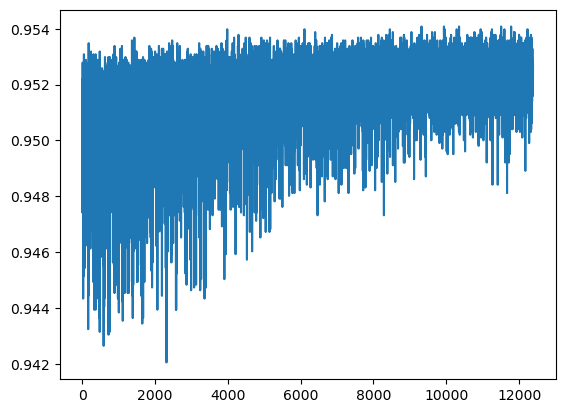

0.045919888679057747 {'idle_loss_rate': 3.3426054572912477e-09, 'idle_error_rate': array([3.25207635e-11, 4.21238068e-10, 3.44007276e-10]), 'entangling_zone_error_rate': array([1.72256625e-06, 3.21233741e-08, 3.34642020e-05]), 'entangling_gate_error_rate': [9.437949997889121e-08, 3.630595770360714e-07, 1.7328407042651017e-05, 9.437949997889121e-08, 0, 0, 0, 3.630595770360714e-07, 0, 0, 0, 1.7328407042651017e-05, 0, 0, 2.8233094005731712e-05], 'entangling_gate_loss_rate': 2.5158494709007797e-05, 'single_qubit_error_rate': array([4.55287850e-08, 5.82794080e-06, 7.18376916e-07]), 'reset_error_rate': 6.4838739476362966e-06, 'measurement_error_rate': 0.0001168915865394908, 'reset_loss_rate': 2.680561246434082e-06, 'measurement_loss_rate': 0.0010985389977136335, 'ancilla_idle_loss_rate': 1.5386079631047721e-09, 'ancilla_idle_error_rate': array([7.98014737e-11, 4.56904008e-10, 4.46654602e-08]), 'ancilla_reset_error_rate': 0.02088622352675797, 'ancilla_measurement_error_rate': 0.00021273492681

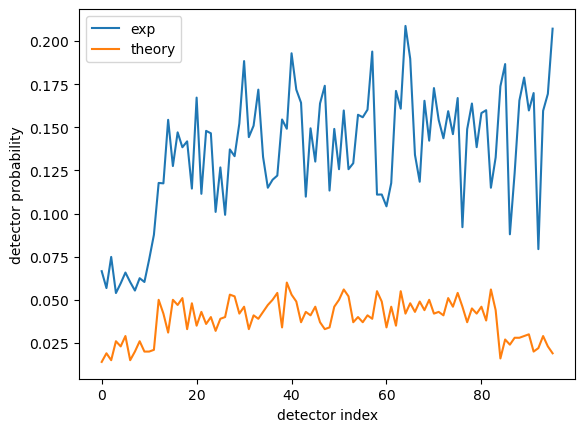

In [1]:
from BiasedErasure.delayed_erasure_decoders.Experimental_Loss_Decoder import *
import numpy as np
import pickle
import cma

# Set parameters
decoder_basis = 'X'
distance = 5
num_rounds = 5

best_loss = 1e9
best_params = None


def optimize_for_detector_match(measurement_events, Meta_params, output_dir, decoder_basis, job_id):
    # Maximum values we want to explore
    baseline = {'idle_loss_rate': 3.924955237995798e-09,
                'idle_error_rate': np.array([8.05949882e-11, 4.76258202e-10, 4.56497181e-09]),
                'entangling_zone_error_rate': np.array([6.90295608e-06, 7.23575982e-08, 7.41148045e-05]),
                'entangling_gate_error_rate': [2.498516172862973e-07, 1.8281090698872218e-06, 3.060781905123361e-05,
                                               2.498516172862973e-07, 0, 0, 0, 1.8281090698872218e-06, 0, 0, 0,
                                               3.060781905123361e-05, 0, 0, 4.113476429587507e-05],
                'entangling_gate_loss_rate': 3.63536055086624e-05,
                'single_qubit_error_rate': np.array([1.81121783e-07, 1.08012494e-05, 1.02295133e-06]),
                'reset_error_rate': 7.25156591908712e-06, 'measurement_error_rate': 0.00015234601953681632,
                'reset_loss_rate': 9.537400334032652e-06, 'measurement_loss_rate': 0.0012898945374973613,
                'ancilla_idle_loss_rate': 1.8591741923450326e-09,
                'ancilla_idle_error_rate': np.array([1.56459515e-09, 5.63155302e-10, 5.19928964e-08]),
                'ancilla_reset_error_rate': 0.02596236043472476 * 0.01,
                'ancilla_measurement_error_rate': 0.00031609618989429113,
                'ancilla_reset_loss_rate': 2.7017833222373136e-06,
                'ancilla_measurement_loss_rate': 3.6264575325860815e-05}

    # Flatten the scaled dictionary into a numpy array for further processing
    baseline = np.array(
        [baseline['idle_loss_rate'], *baseline['idle_error_rate'], *baseline['entangling_zone_error_rate'],
         *(np.take(baseline['entangling_gate_error_rate'], [0, 1, 2, 14])),
         baseline['entangling_gate_loss_rate'],
         *baseline['single_qubit_error_rate'], baseline['reset_error_rate'], baseline['measurement_error_rate'],
         baseline['reset_loss_rate'], baseline['measurement_loss_rate'],
         baseline['ancilla_idle_loss_rate'], *baseline['ancilla_idle_error_rate'],
         baseline['ancilla_reset_error_rate'], baseline['ancilla_measurement_error_rate'],
         baseline['ancilla_reset_loss_rate'], baseline['ancilla_measurement_loss_rate']]) * 100

    # Set a unique random seed based on the job_id to ensure different initial points for each job
    np.random.seed(job_id)

    # Generate a unique initial point for each job based on the random seed
    initial_point = np.random.uniform(low=-np.log(10), high=np.log(10), size=len(baseline))

    def objective(noise_params):
        # Scale the baseline by the noise parameters
        noise_params = baseline / (1 + np.exp(-np.array(noise_params)))
        print(noise_params)
        noise_params = dict(
            idle_loss_rate=noise_params[0],
            idle_error_rate=noise_params[1:4],
            entangling_zone_error_rate=noise_params[4:7],
            entangling_gate_error_rate=[noise_params[7], noise_params[8], noise_params[9], noise_params[7],
                                        0, 0, 0, noise_params[8], 0, 0, 0, noise_params[9], 0, 0, noise_params[10]],
            entangling_gate_loss_rate=noise_params[11],
            single_qubit_error_rate=noise_params[12:15],
            reset_error_rate=noise_params[15],
            measurement_error_rate=noise_params[16],
            reset_loss_rate=noise_params[17],
            measurement_loss_rate=noise_params[18],
            ancilla_idle_loss_rate=noise_params[19],
            ancilla_idle_error_rate=noise_params[20:23],
            ancilla_reset_error_rate=noise_params[23],
            ancilla_measurement_error_rate=noise_params[24],
            ancilla_reset_loss_rate=noise_params[25],
            ancilla_measurement_loss_rate=noise_params[26],
            gate_noise=LogicalCircuit.ancilla_data_differentiated_gate_noise,
            idle_noise=LogicalCircuit.ancilla_data_differentiated_idle_noise
        )

        simulated_measurements, simulated_detectors, simulated_observables, circuit = get_simulated_measurement_events(
            Meta_params, distance, distance, 1000, noise_params=noise_params)
        detection_events, observable_flips = circuit.compile_m2d_converter().convert(
            measurements=measurement_events.astype(bool), separate_observables=True)


        loss = np.mean(np.abs(np.mean(detection_events, axis=0) - np.mean(simulated_detectors, axis=0)))

        # Save intermediate results
        with open(f'intermediate_results_cma_update_noise_model_{decoder_basis}_detectors.pkl', 'ab') as f:
            pickle.dump({'params': noise_params, 'loss': loss}, f)
        print(f"intermediate fidelity = {1 - loss}")

        return loss

    # Perform optimization using CMA-ES with the unique initial point for each job
    xopt, es = cma.purecma.fmin(
        lambda x: objective(x), initial_point, 0.5,
        maxfevals=1000, verb_disp=1, verb_log=1, verb_save=1)

    # Save final results
    with open(f'final_results_gradient_{decoder_basis}_detectors..pkl', 'wb') as f:
        pickle.dump({'params': xopt, 'result': es}, f)

    return xopt, es


# Load measurement events
measurement_events = np.load(f'measurement_events_{decoder_basis}_NZZrNr_2024_10_06.npy')#[:1000, :]
train_measurement_events = measurement_events[::2]
test_measurement_events = (measurement_events[1:])[::2]
output_dir = '.'


# Split data into training and testing, first half is training
num_of_shots = len(measurement_events) // 2
train_measurement_events = measurement_events[::2]
gate_ordering = ['N', 'Z', 'Zr', 'Nr']

# Set Meta_params and output directory
Meta_params = {
    'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
    'bias_preserving_gates': 'False', 'noise': 'atom_array', 'is_erasure_biased': 'False',
    'LD_freq': '1000', 'LD_method': 'None', 'SSR': 'True', 'cycles': str(num_rounds - 1),
    'ordering': gate_ordering, 'decoder': 'MLE', 'circuit_type': 'memory',
    'Steane_type': 'regular', 'printing': 'False', 'num_logicals': '1',
    'loss_decoder': 'independent', 'obs_pos': 'd-1', 'n_r': '0', 'circuit_index': 0
}

#optimize_for_detector_match(measurement_events, Meta_params, output_dir, decoder_basis, 0)
folder = '/Users/gefenbaranes/Documents/CX_experiment'
losses = []
with (open(f'{folder}/intermediate_results_cma_update_noise_model_X_v3.pkl', "rb")) as openfile:
    while True:
        try:
            data = pickle.load(openfile)
            params = data['params']
            loss = data['loss']
            losses.append(1-loss)
            if loss < best_loss:
                best_loss = loss
                best_params = params
        except EOFError:
            break
plt.plot(losses)
plt.show()
print(best_loss, best_params)

# Now let's decode!
use_loss_decoding = True  # if False: use same DEM every shot, without utilizing SSR.
use_independent_decoder = True  # if False: in every lifecycle, we just apply supercheck at the end. If True: we count the full lifecycle with different potential loss locations and corresponding Clifford propagations.
use_independent_and_first_comb_decoder = False  # This is relevant only if use_independent_decoder=True. If False: use only independent lifecycles. If True: adds a single combination of lifecycles to the decoder.
output_dir = '.'
simulate_data = False

simulated_measurements, simulated_detectors, simulated_observables, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1000, noise_params=best_params)
detection_events, observable_flips = circuit.compile_m2d_converter().convert(measurements=measurement_events.astype(bool), separate_observables=True)
plt.plot(np.mean(detection_events, axis=0), label='exp')
plt.plot(np.mean(simulated_detectors, axis=0), label='theory')
plt.ylabel('detector probability')
plt.xlabel('detector index')
plt.legend()
plt.show()

In [2]:



_, _, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1, best_params)

detection_events, observable_flips = circuit.compile_m2d_converter().convert(measurements=measurement_events.astype(bool), separate_observables=True)
detection_events_signs_theory = -np.sign(2*np.nanmean(detection_events.astype(int), axis=0)-1).astype(int)
print(detection_events_signs_theory) # needs to be all +1


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [9]:
print(circuit)

R 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46
X_ERROR(6.48387e-06) 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46
I 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46
SQRT_Y_DAG 2 4 6 13 15 22 24 26 33 35 42 44 46
PAULI_CHANNEL_1(4.55288e-08, 5.82794e-06, 7.18377e-07) 2 4 6 13 15 22 24 26 33 35 42 44 46
TICK
R 7 9 11 17 19 21 27 29 31 37 39 41 0 1 8 10 18 20 28 30 38 40 47 48
X_ERROR(0.0208862) 0 1 7 8 9 10 11 17 18 19 20 21 27 28 29 30 31 37 38 39 40 41 47 48
I 0 1 7 8 9 10 11 17 18 19 20 21 27 28 29 30 31 37 38 39 40 41 47 48
SQRT_Y 7 9 11 17 19 21 27 29 31 37 39 41 0 1 8 10 18 20 28 30 38 40 47 48
PAULI_CHANNEL_1(4.55288e-08, 5.82794e-06, 7.18377e-07) 7 9 11 17 19 21 27 29 31 37 39 41 0 1 8 10 18 20 28 30 38 40 47 48
CZ 2 0 4 1 13 8 15 10 22 18 24 20 33 28 35 30 42 38 44 40 7 12 9 14 11 16 19 23 21 25 27 32 29 34 31 36 39 43 41 45
PAULI_CHANNEL_2(9.43795e-08, 3.6306e-07, 1.73284e-05, 9.43795e-08, 0, 0, 0, 3.6306e-07